# LSTM & Word Embeddings for Sentiment Classification

RNNs are commonly applied to various natural language processing tasks. We've already encountered sentiment analysis using text data in part three of [this book](https://www.amazon.com/Hands-Machine-Learning-Algorithmic-Trading-ebook/dp/B07JLFH7C5/ref=sr_1_2?ie=UTF8&qid=1548455634&sr=8-2&keywords=machine+learning+algorithmic+trading).

We are now going to illustrate how to apply an RNN model to text data to detect positive or negative sentiment (which can easily be extended to a finer-grained sentiment scale). We are going to use word embeddings to represent the tokens in the documents. We covered word embeddings in Chapter 15, Word Embeddings. They are an excellent technique to convert text into a continuous vector representation such that the relative location of words in the latent space encodes useful semantic aspects based on the words' usage in context.

We saw in the previous RNN example that Keras has a built-in embedding layer that allows us to train vector representations specific to the task at hand. Alternatively, we can use pretrained vectors.

## Imports & Settings

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import minmax_scale

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, Input, concatenate, Embedding, Reshape
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
import tensorflow.keras.backend as K

In [2]:
sns.set_style('whitegrid')
np.random.seed(42)
K.clear_session()

## Load Reviews

To keep the data manageable, we will illustrate this use case with the IMDB reviews dataset, which contains 50,000 positive and negative movie reviews evenly split into a train and a test set, and with balanced labels in each dataset. The vocabulary consists of 88,586 tokens.

The dataset is bundled into Keras and can be loaded so that each review is represented as an integer-encoded sequence. We can limit the vocabulary to num_words while filtering out frequent and likely less informative words using skip_top, as well as sentences longer than maxlen. We can also choose oov_char, which represents tokens we chose to exclude from the vocabulary on frequency grounds, as follows:

In [3]:
vocab_size = 20000

In [4]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(seed=42, 
                                                      skip_top=0,
                                                      maxlen=None, 
                                                      oov_char=2, 
                                                      index_from=3,
                                                      num_words=vocab_size)

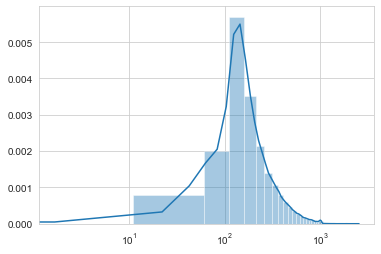

In [5]:
ax = sns.distplot([len(review) for review in X_train])
ax.set(xscale='log');

## Prepare Data

In the second step, convert the lists of integers into fixed-size arrays that we can stack and provide as input to our RNN. The pad_sequence function produces arrays of equal length, truncated, and padded to conform to maxlen, as follows:

In [6]:
maxlen = 100

In [7]:
X_train_padded = pad_sequences(X_train, 
                        truncating='pre', 
                        padding='pre', 
                        maxlen=maxlen)

X_test_padded = pad_sequences(X_test, 
                       truncating='pre', 
                       padding='pre', 
                       maxlen=maxlen)

In [8]:
X_train_padded.shape, X_test_padded.shape

((25000, 100), (25000, 100))

## Define Model Architecture

Now we can define our RNN architecture. The first layer learns the word embeddings. We define the embedding dimension as previously using the input_dim keyword to set the number of tokens that we need to embed, the output_dim keyword, which defines the size of each embedding, and how long each input sequence is going to be.

### Custom Loss Metric

In [9]:
embedding_size = 100

Note that we are using GRUs this time, which train faster and perform better on smaller data. We are also using dropout for regularization, as follows:

In [10]:
rnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim= embedding_size, input_length=maxlen),
    GRU(units=32,  dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
gru (GRU)                    (None, 32)                12864     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 2,012,897
Trainable params: 2,012,897
Non-trainable params: 0
_________________________________________________________________


The resulting model has over 2 million parameters.

We compile the model to use our custom AUC metric, which we introduced previously, and train with early stopping:

In [11]:
rnn.compile(loss='binary_crossentropy', 
            optimizer='RMSProp', 
            metrics=['accuracy', 
                     tf.keras.metrics.AUC(name='AUC')])

In [12]:
early_stopping = EarlyStopping(monitor='val_AUC', 
                               mode='max',
                              patience=5,
                              restore_best_weights=True)

Training stops after eight epochs and we recover the weights for the best models to find a high test AUC of 0.9346:

In [13]:
training = rnn.fit(X_train_padded,
                   y_train,
                   batch_size=32,
                   epochs=100,
                   validation_data=(X_test_padded, y_test),
                   callbacks=[early_stopping],
                   verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/100
25000/25000 [==============================] - 80s 3ms/sample - loss: 0.4920 - accuracy: 0.7612 - AUC: 0.8440 - val_loss: 0.3976 - val_accuracy: 0.8252 - val_AUC: 0.9065
Epoch 2/100
25000/25000 [==============================] - 78s 3ms/sample - loss: 0.3437 - accuracy: 0.8565 - AUC: 0.9269 - val_loss: 0.3485 - val_accuracy: 0.8497 - val_AUC: 0.9275
Epoch 3/100
25000/25000 [==============================] - 78s 3ms/sample - loss: 0.2769 - accuracy: 0.8909 - AUC: 0.9524 - val_loss: 0.3393 - val_accuracy: 0.8559 - val_AUC: 0.9371
Epoch 4/100
25000/25000 [==============================] - 78s 3ms/sample - loss: 0.2342 - accuracy: 0.9098 - AUC: 0.9659 - val_loss: 0.3266 - val_accuracy: 0.8630 - val_AUC: 0.9393
Epoch 5/100
25000/25000 [==============================] - 78s 3ms/sample - loss: 0.2064 - accuracy: 0.9210 - AUC: 0.9734 - val_loss: 0.3398 - val_accuracy: 0.8530 - val_AUC: 0.9410
Epoch 6/100
25000/25000 [===============

## Evaluate Results

In [14]:
df = pd.DataFrame(training.history)
df.to_csv('lstm_sa.csv', index=False)

In [17]:
df

,loss,accuracy,AUC,val_loss,val_accuracy,val_AUC
0,0.491969,0.76116,0.843963,0.397625,0.82524,0.906470
1,0.343732,0.85652,0.926933,0.348452,0.84972,0.927469
2,0.276921,0.89092,0.952440,0.339346,0.85592,0.937061
3,0.234235,0.90984,0.965913,0.326631,0.86304,0.939331
4,0.206356,0.92100,0.973420,0.339808,0.85304,0.940975
5,0.182318,0.93196,0.978867,0.328015,0.86276,0.939985
6,0.164431,0.93876,0.982735,0.336437,0.86216,0.940456
7,0.146919,0.94628,0.985811,0.349640,0.85696,0.938704
8,0.130508,0.95240,0.988647,0.376018,0.85628,0.935913
9,0.117153,0.95900,0.990391,0.404351,0.84796,0.932601


In [15]:
y_score = rnn.predict(X_test_padded)
y_score.shape


(25000, 1)

In [16]:
roc_auc_score(y_score=y_score.squeeze(), y_true=y_test)

0.9409882079999999